In [23]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import cbn_datagen as cbn_dg
import cbn_ae_datagen as cbn_ae_dg

import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow.keras as keras
import tensorflow as tf
import pickle
import numpy as np
import scipy
from scipy.signal import find_peaks
from sklearn.metrics import classification_report

from metrics import *

# receiver antennas
N = 16

# bits
L = 16

# no. of sources
K = 8

C = [8, 16, 32]

# snr between 5 and 30 dB
snrs = [5, 10, 15, 20, 25, 30]

resolution = 180
samples = 2000

cbn_cov_labels, cbn_cov_data = cbn_dg.generate_bulk_data(samples, N, K, L)
cbn_autoenc_labels, cbn_autoenc_data = cbn_ae_dg.generate_bulk_data(samples, N, K, L)

In [24]:
mse_cbn = []
    
acc_cbn = []

cbn_cov_model = load_model(f"models/CBN_N={N}_K={K}_L={L}")

def cbn_cov(model, data_, labels_, snr):
    labels = np.copy(labels_)
    data = np.copy(data_)
    data = cbn_dg.apply_wgn(data, L, snr).reshape((samples, L, N))
    data = cbn_dg.compute_cov(data)/L
    data = cbn_dg.normalize(data, snr)
        
    pred = model.predict(data)
        
    pred = pred / np.max(pred, axis=1).reshape(samples,1)
    
    
    pred_conv = np.zeros((len(labels), K))
    labels_conv = np.zeros((len(labels), K))
    
        
    for i in range(len(pred)):
        n = int(np.sum(labels[i]))
        pred_theta = (-pred[i]).argsort()[:n].copy()        
        pred_theta.sort()
        pred_conv[i][:n] = pred_theta / 180 * np.pi - np.pi/2
        
        pred[i][pred[i] < 0.5] = 0
        pred[i][pred[i] >= 0.5] = 1
        
        temp = (-labels[i]).argsort()[:n].copy()
        temp.sort()
        labels_conv[i][:n] = temp / 180 * np.pi - np.pi/2
        
    
    m = np.mean((labels_conv - pred_conv)**2, axis=1) / np.sum(labels_conv**2, axis=1)
    m = np.mean(m)
    acc_pos_ = compute_pos_acc(labels, pred)
        
    mse_cbn.append(m)
    acc_cbn.append(acc_pos_)
    
for s in snrs:
    snr = [s, s]
    print(s)
    cbn_cov(cbn_cov_model, cbn_cov_data, cbn_cov_labels, snr)

5
10
15
20
25
30


In [25]:
acc_cbn

[0.9264277777777762,
 0.9359305555555525,
 0.9382722222222188,
 0.9389999999999968,
 0.9390805555555534,
 0.9392138888888867]

In [41]:
cbn_ae_type = 'CBN_ae_out'

cbn_ae_legend = 'cbn autoenc'

mse_cbn_ae = {}
    
acc_cbn_ae = {}

for c in C:
    mse_cbn_ae[f'{cbn_ae_legend} C={c}'] = []
    acc_cbn_ae[f'{cbn_ae_legend} C={c}'] = []

    
def cbn_autoenc(model, autoenc, data_, labels_, snr, c):
    labels = np.copy(labels_)
    data = np.copy(data_)
    
    data = cbn_ae_dg.apply_wgn(data, L, snr).reshape((samples, L*N))
    data = np.concatenate((data.real,data.imag), axis=1)
    data = data - np.min(data, axis=1).reshape((samples, 1))
    data = data / np.max(np.abs(data), axis=1).reshape((samples, 1))

    data = autoenc(data)
    
    #print(data.shape)
    
    pred = model.predict(data)
        
    pred = pred / np.max(pred, axis=1).reshape(samples,1)
        
    pred_conv = np.zeros((len(pred), K))
    labels_conv = np.zeros((len(pred), K))
    
        
    for i in range(len(pred)):
        n = int(np.sum(labels[i]))
        pred_theta = (-pred[i]).argsort()[:n].copy()        
        pred_theta.sort()
        pred_conv[i][:n] = pred_theta / 180 * np.pi - np.pi/2
        
        pred[i][pred[i] < 0.5] = 0
        pred[i][pred[i] >= 0.5] = 1
        
        temp = (-labels[i]).argsort()[:n].copy()
        temp.sort()
        labels_conv[i][:n] = temp / 180 * np.pi - np.pi/2
        
    m = np.mean((labels_conv - pred_conv)**2, axis=1) / np.sum(labels_conv**2, axis=1)
    m = np.mean(m)
    acc_pos_ = compute_pos_acc(labels, pred)
        
    mse_cbn_ae[f'{cbn_ae_legend} C={c}'].append(m)
    acc_cbn_ae[f'{cbn_ae_legend} C={c}'].append(acc_pos_)
    

cbn_autoenc_models = []
autoencoder_models = []

for c in C:
    cbn_autoenc_models.append(load_model(f"models/{cbn_ae_type}_C={c}_N={N}_K={K}_L={L}"))
    autoencoder_models.append(load_model(f"models/AE_C={c}_N={N}_K={K}_L={L}").layers[1])


for s in snrs:
    snr = [s, s]
    print(s)    
    for c in C:
        i = C.index(c)
        cbn_autoenc(cbn_autoenc_models[i], autoencoder_models[i], cbn_autoenc_data, cbn_autoenc_labels, snr, c)      
        
        


5
10
15
20
25
30


In [42]:
acc_cbn_ae

{'cbn autoenc C=8': [0.7988972222222208,
  0.8477555555555534,
  0.8644916666666638,
  0.8701055555555546,
  0.8719833333333316,
  0.8732694444444422],
 'cbn autoenc C=16': [0.86351111111111,
  0.883377777777775,
  0.8907138888888863,
  0.8946944444444416,
  0.8958222222222185,
  0.8966444444444418],
 'cbn autoenc C=32': [0.8918944444444428,
  0.9006805555555537,
  0.9048444444444408,
  0.906138888888885,
  0.9071722222222177,
  0.9072749999999957]}

'\nplt.figure(3)\n\ncbn_history = pickle.load(open(f"history/CBN_N={N}_K={K}_L={L}", \'rb\'))\nplt.plot(cbn_history[\'loss\'])\nplt.plot(cbn_history[\'val_loss\'])\nplt.legend([\'training\', \'validation\'])\nplt.xlabel(\'epoch\')\nplt.ylabel(\'binary cross entropy\')\nplt.savefig(f"figures/experiment_cbn_vb_cbn_autoenc/CBN_loss_N={N}_K={K}_L={L}.png", format=\'png\')\n'

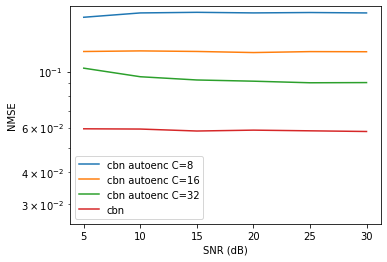

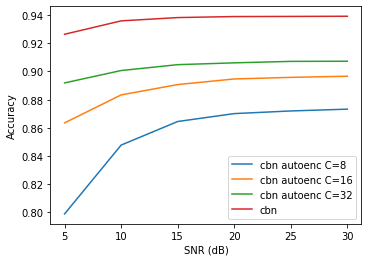

In [45]:
mse = mse_cbn_ae
mse['cbn'] = mse_cbn

acc = acc_cbn_ae
acc['cbn'] = acc_cbn

plt.figure(0)
plt.gcf().subplots_adjust(left=0.18)
for i in list(mse.keys()):
    plt.semilogy(snrs, mse[i])

plt.ylabel('NMSE')
plt.xlabel('SNR (dB)')
plt.ylim([0.025, None])
plt.legend(list(mse.keys()))
plt.savefig(f'figures/experiment_cbn_vb_cbn_autoenc/{cbn_ae_type}_mse_N={N}_K={K}_L={L}.png')

plt.figure(1)
plt.gcf().subplots_adjust(left=0.18)

for i in list(acc.keys()):
    plt.plot(snrs, acc[i])
    
plt.ylabel('Accuracy')
plt.xlabel('SNR (dB)')
plt.legend(list(acc.keys()))
#plt.ylim([0.83, None])
plt.savefig(f'figures/experiment_cbn_vb_cbn_autoenc/{cbn_ae_type}_acc_pos_N={N}_K={K}_L={L}.png')

"""
plt.figure(3)

cbn_history = pickle.load(open(f"history/CBN_N={N}_K={K}_L={L}", 'rb'))
plt.plot(cbn_history['loss'])
plt.plot(cbn_history['val_loss'])
plt.legend(['training', 'validation'])
plt.xlabel('epoch')
plt.ylabel('binary cross entropy')
plt.savefig(f"figures/experiment_cbn_vb_cbn_autoenc/CBN_loss_N={N}_K={K}_L={L}.png", format='png')
"""


In [ ]:
for k in [4,8]:
    for c in [8,16,32]:
        for network in ['CBN_ae_untrained', 'CBN_ae', 'CBN_ae_out']:
            plt.figure()

            cbn_ae_history = pickle.load(open(f"history/{network}_C={c}_N={N}_K={k}_L={L}", 'rb'))
            plt.plot(cbn_ae_history['loss'])
            plt.plot(cbn_ae_history['val_loss'])
            plt.legend(['training', 'validation'])
            plt.xlabel('epoch')
            plt.ylabel('binary cross entropy')
            plt.savefig(f"figures/experiment_cbn_vb_cbn_autoenc/{network}_loss_C={c}_N={N}_K={k}_L={L}.png", format='png')

In [ ]:
autoenc_mse = {}

samples = 20000
    
K = 8
C = [8, 16, 32]

cbn_autoenc_labels, cbn_autoenc_data = cbn_ae_dg.generate_bulk_data(samples, N, K, L)

for c in C:
    autoenc_model = load_model(f"models/AE_C={c}_N={N}_K={K}_L={L}")
    

    for s in snrs:
        snr = [s, s]
        print(s)
        
        data = np.copy(cbn_autoenc_data)
    
        data = cbn_ae_dg.apply_wgn(data, L, snr).reshape((samples, L*N))
        data = np.concatenate((data.real,data.imag), axis=1)    
        data = data - np.min(data, axis=1).reshape((samples, 1))
        data = data / np.max(np.abs(data), axis=1).reshape((samples, 1))
        #data = data / np.max(np.abs(data), axis=1).reshape((samples, 1))
        
        pred = autoenc_model.predict(data)
        
        #print(data.dtype)
        
        m = tf.cast(tf.keras.losses.MSE(data, pred), tf.float64) / tf.reduce_sum(data**2, axis=1)

        a_mse = tf.reduce_mean(m).numpy()
        
        name = f'autoenc C={c}'
        
        if name not in autoenc_mse:
            autoenc_mse[name] = []
        
        autoenc_mse[name].append(a_mse)
        
    plt.figure()
    plt.gcf().subplots_adjust(left=0.18)    
    plt.ylabel('Autoencoder output')
    plt.xlabel(f'Autoencoder input')
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.scatter(data[0], pred[0])

    plt.savefig(f'figures/experiment_cbn_vb_cbn_autoenc/autoenc_scatter_C={c}_N={N}_K={K}_L={L}.png')
    
plt.figure(6)
plt.gcf().subplots_adjust(left=0.18)
for i in list(autoenc_mse.keys()):
    plt.semilogy(snrs, autoenc_mse[i])

plt.ylabel('MSE')
plt.xlabel('SNR (dB)')
plt.legend(list(autoenc_mse.keys()))
plt.savefig(f'figures/experiment_cbn_vb_cbn_autoenc/autoenc_mse_N={N}_K={K}_L={L}.png')



In [ ]:
autoenc_mse = {}
    
K = 8
C = [32]

for c in C:
    autoenc_model = load_model(f"models/AE_C={c}_N={N}_K={K}_L={L}")

    cbn_autoenc_labels, cbn_autoenc_data = cbn_ae_dg.generate_bulk_data(samples, N, K, L)

    for s in snrs:
        snr = [s, s]
        print(s)
                
        data = np.copy(cbn_autoenc_data)
    
        data = cbn_ae_dg.apply_wgn(data, L, snr).reshape((samples, L*N))
        data = np.concatenate((data.real,data.imag), axis=1)    
        data = data - np.min(data, axis=1).reshape((samples, 1))
        data = data / np.max(np.abs(data), axis=1).reshape((samples, 1))
        
        pred = autoenc_model.predict(data)
        
        m = tf.keras.losses.mean_squared_error(data.T, pred.T)
        a_mse = tf.reduce_mean(m).numpy()
        
        name = f'autoenc C={c}'
        
        if name not in autoenc_mse:
            autoenc_mse[name] = []
        
        autoenc_mse[name].append(a_mse)
        
    plt.figure()
        
    plt.ylabel('Autoencoder output')
    plt.xlabel(f'Autoencoder input C = {c}, SNR = 30dB')
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.scatter(data[0], pred[0])

        
plt.figure(6)
for i in list(autoenc_mse.keys()):
    plt.semilogy(snrs, autoenc_mse[i])
    autoenc_mse[i].clear()

plt.ylabel('MSE')
plt.xlabel('SNR (dB)')
#plt.ylim([None, 5e-5])
plt.legend(list(autoenc_mse.keys()))



In [ ]:
mse